In [2]:
import dask
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmcrameri as cm
import os
import matplotlib.gridspec as gridspec  
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
import babet as bb
import atmicp

In [4]:
atmicp.Constants.palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.5882352941176471, 0.2901960784313726, 0.5450980392156862),
 (0.611764705882353, 0.611764705882353, 0.6313725490196078),
 (0.47843137254901963, 0.12941176470588237, 0.8666666666666667)]

In [5]:
def diff_with_offset(a, b, dim="inidate", offset=1):
    return a.isel({dim: slice(0, -offset)}) - b.isel({dim: slice(offset, None)})

# Import data

In [6]:
ifs025 = atmicp.Data.get_ifs_data(res='US025')

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/noback

In [7]:
ifs100 = atmicp.Data.get_ifs_data(res='GLO100')

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/noback

# Time series of deltas

In [ ]:
# global at 00UTC difference to the previous initidalisation

deltas100 = {}
for climate in ['pi', 'incr']:
    deltas100[climate] = {}
    for pert in ['t+q', 'progn_vars']:
        tmp1 = ifs100.sel(perturbation=pert, climate=climate)
        tmp2 = ifs100.sel(perturbation='none', climate='curr')
        ifs_diff = diff_with_offset(tmp1, tmp2, dim='inidate', offset=1)

        ifs_diff_delta = []

        for i, ini in enumerate(ifs_diff.inidate.values):
            inidate_data = ifs_diff.sel(inidate=ini)
            timesteps = [ini+np.timedelta64(0,'h')] #[ini+np.timedelta64(0, 'h'), ini+np.timedelta64(24, 'h')]
            ifs_diff_delta.append(inidate_data.sel(time=timesteps).squeeze('time', drop=True))

        ifs_diff_delta = xr.concat(ifs_diff_delta, dim='inidate')
        deltas100[climate][pert] = ifs_diff_delta.mean(dim=['number', 'latitude', 'longitude']).compute()

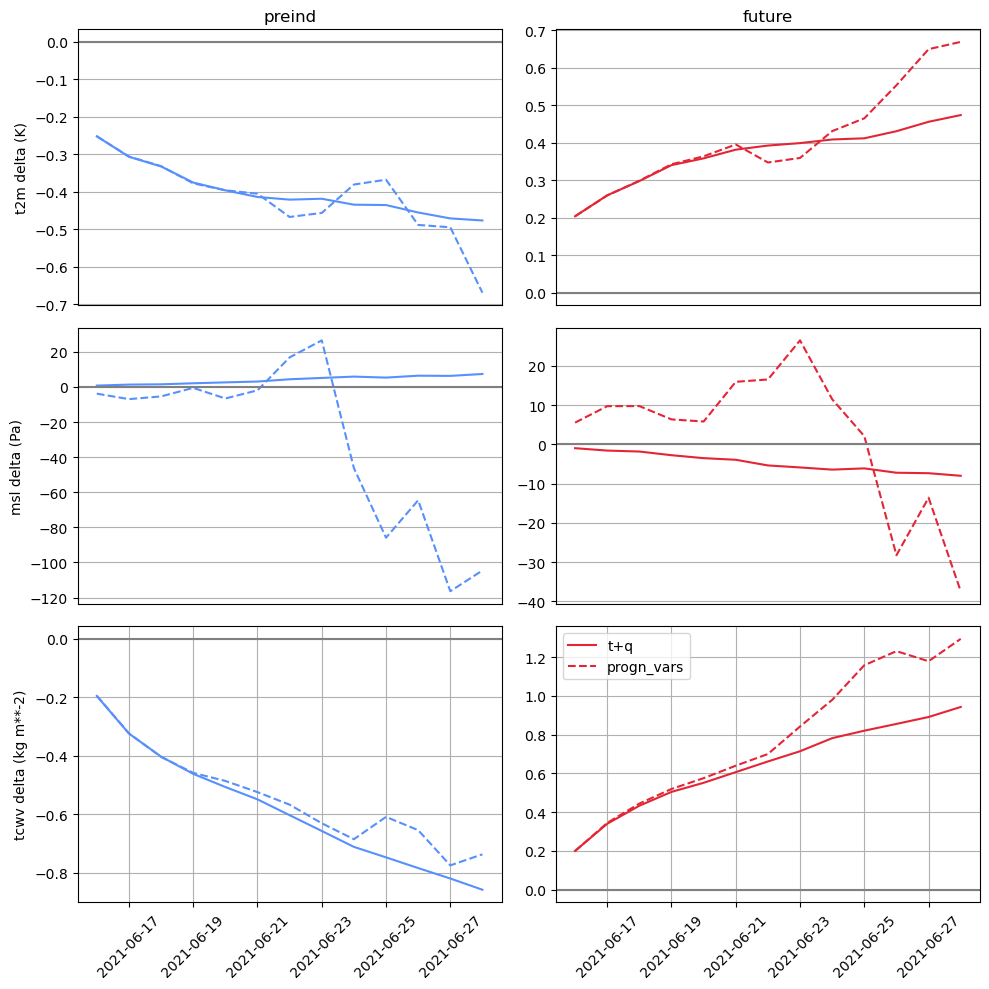

In [ ]:
plt.figure(figsize=(10,10))
for v, var in enumerate(['t2m', 'msl', 'tcwv']):
    ax = plt.subplot(3,2,1+v*2)
    ax.plot(deltas100['pi']['t+q'].inidate, deltas100['pi']['t+q'][var], color=atmicp.Constants.palette[0], linestyle='-')
    ax.plot(deltas100['pi']['progn_vars'].inidate, deltas100['pi']['progn_vars'][var], color=atmicp.Constants.palette[0], linestyle='--')
    plt.ylabel(f'{var} delta ({ifs100[var].units})')
    plt.axhline(0, color='gray', linestyle='-')
    plt.grid()

    if v == 2:
        plt.xticks(rotation=45)
    elif v == 0:
        plt.title('preind')
        ax.set_xticks([])
    elif v == 1:
        ax.set_xticks([])

    ax = plt.subplot(3,2,2+v*2)
    ax.plot(deltas100['incr']['t+q'].inidate, deltas100['incr']['t+q'][var],  color=atmicp.Constants.palette[2], linestyle='-', label='t+q')
    ax.plot(deltas100['incr']['progn_vars'].inidate, deltas100['incr']['progn_vars'][var], color=atmicp.Constants.palette[2], linestyle='--', label='progn_vars')
    plt.ylabel('')
    plt.axhline(0, color='gray', linestyle='-')
    plt.grid()

    if v == 2:
        plt.xticks(rotation=45)
        plt.legend(loc='upper left')
    elif v == 0:
        plt.title('future')
        ax.set_xticks([])
    elif v == 1:
        ax.set_xticks([])

plt.tight_layout()
plt.savefig('../figures/02_ifs_global_deltas.png', dpi=600)

In [12]:
# global at 00UTC difference to the previous initidalisation

deltas025 = {}
for climate in ['pi', 'incr']:
    deltas025[climate] = {}
    for pert in ['t+q', 'progn_vars']:
        tmp1 = ifs025.sel(perturbation=pert, climate=climate)
        tmp2 = ifs025.sel(perturbation='none', climate='curr')
        ifs_diff = diff_with_offset(tmp1, tmp2, dim='inidate', offset=1)

        ifs_diff_delta = []

        for i, ini in enumerate(ifs_diff.inidate.values):
            inidate_data = ifs_diff.sel(inidate=ini)
            timesteps = [ini+np.timedelta64(0,'h')] #[ini+np.timedelta64(0, 'h'), ini+np.timedelta64(24, 'h')]
            ifs_diff_delta.append(inidate_data.sel(time=timesteps).squeeze('time', drop=True))

        ifs_diff_delta = xr.concat(ifs_diff_delta, dim='inidate')
        deltas025[climate][pert] = ifs_diff_delta.mean(dim=['number', 'latitude', 'longitude']).compute()

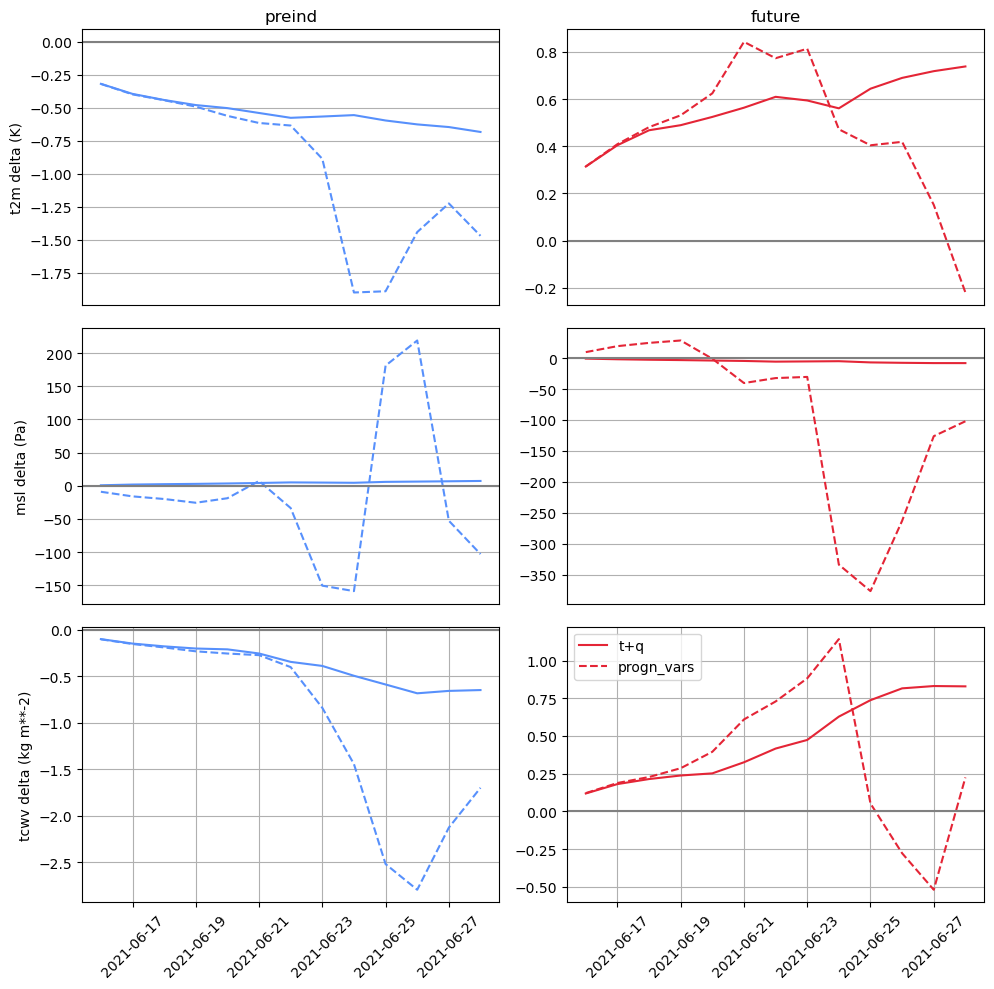

In [13]:
plt.figure(figsize=(10,10))
for v, var in enumerate(['t2m', 'msl', 'tcwv']):
    ax = plt.subplot(3,2,1+v*2)
    ax.plot(deltas025['pi']['t+q'].inidate, deltas025['pi']['t+q'][var], color=atmicp.Constants.palette[0], linestyle='-')
    ax.plot(deltas025['pi']['progn_vars'].inidate, deltas025['pi']['progn_vars'][var], color=atmicp.Constants.palette[0], linestyle='--')
    plt.ylabel(f'{var} delta ({ifs100[var].units})')
    plt.axhline(0, color='gray', linestyle='-')
    plt.grid()

    if v == 2:
        plt.xticks(rotation=45)
    elif v == 0:
        plt.title('preind')
        ax.set_xticks([])
    elif v == 1:
        ax.set_xticks([])

    ax = plt.subplot(3,2,2+v*2)
    ax.plot(deltas025['incr']['t+q'].inidate, deltas025['incr']['t+q'][var],  color=atmicp.Constants.palette[2], linestyle='-', label='t+q')
    ax.plot(deltas025['incr']['progn_vars'].inidate, deltas025['incr']['progn_vars'][var], color=atmicp.Constants.palette[2], linestyle='--', label='progn_vars')
    plt.ylabel('')
    plt.axhline(0, color='gray', linestyle='-')
    plt.grid()

    if v == 2:
        plt.xticks(rotation=45)
        plt.legend(loc='upper left')
    elif v == 0:
        plt.title('future')
        ax.set_xticks([])
    elif v == 1:
        ax.set_xticks([])

plt.tight_layout()
plt.savefig('../figures/02_ifs_USwestcoast_deltas.png', dpi=600)

# Maps of surface deltas

In [8]:
# global at 00UTC difference to the previous initidalisation

delta_maps100 = {}
for climate in ['pi', 'incr']:
    delta_maps100[climate] = {}
    for pert in ['t+q', 'progn_vars']:
        tmp1 = ifs100.sel(perturbation=pert, climate=climate)
        tmp2 = ifs100.sel(perturbation='none', climate='curr')
        ifs_diff = diff_with_offset(tmp1, tmp2, dim='inidate', offset=1)

        ifs_diff_delta = []

        for i, ini in enumerate(ifs_diff.inidate.values):
            inidate_data = ifs_diff.sel(inidate=ini)
            timesteps = [ini+np.timedelta64(0,'h')] #[ini+np.timedelta64(0, 'h'), ini+np.timedelta64(24, 'h')]
            ifs_diff_delta.append(inidate_data.sel(time=timesteps).squeeze('time', drop=True))

        ifs_diff_delta = xr.concat(ifs_diff_delta, dim='inidate')
        delta_maps100[climate][pert] = ifs_diff_delta.mean(dim=['number']).compute()

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/xarray/plot/plot.py:1420: UserWarning: The following kwargs were not used by contour: 'title'
  primitive = ax.contourf(x, y, z, **kwargs)


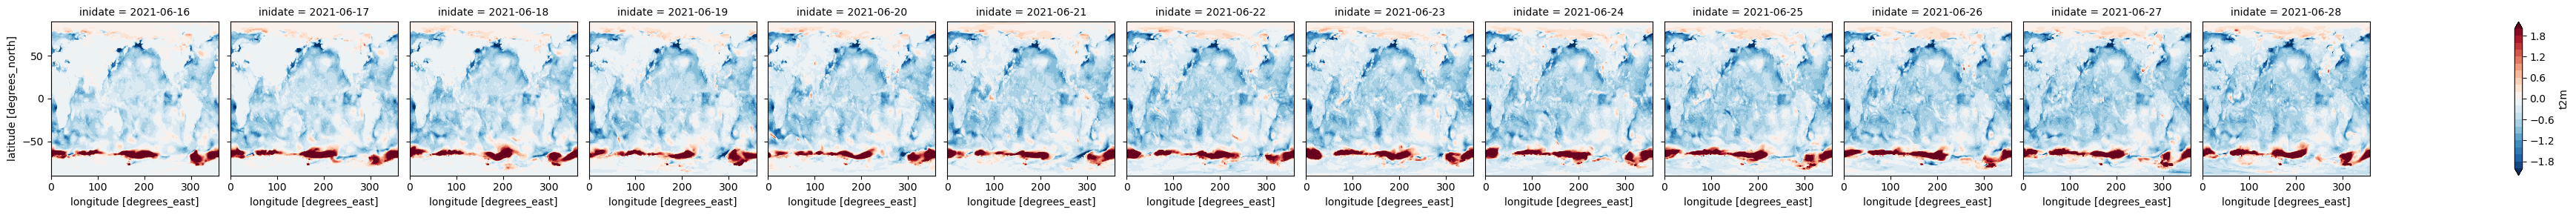

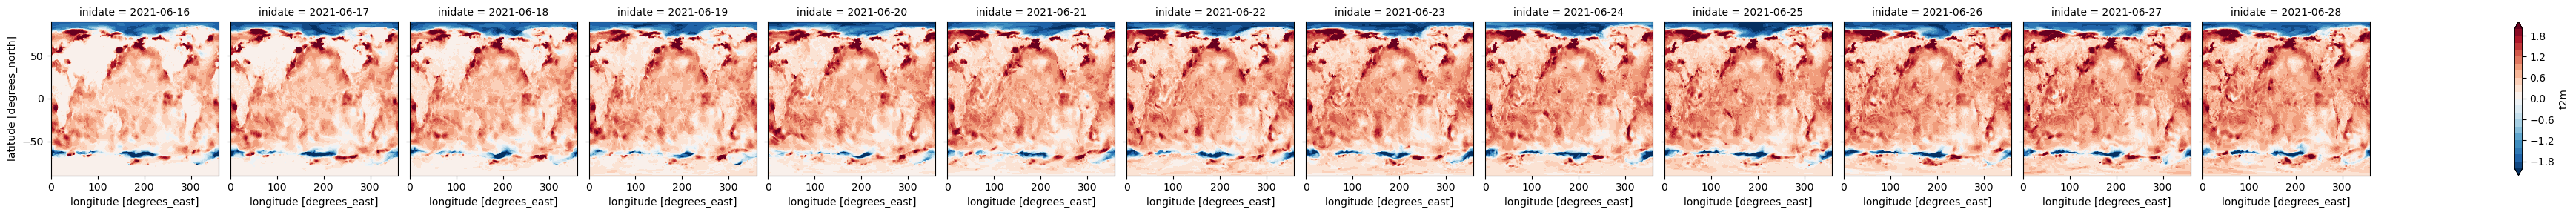

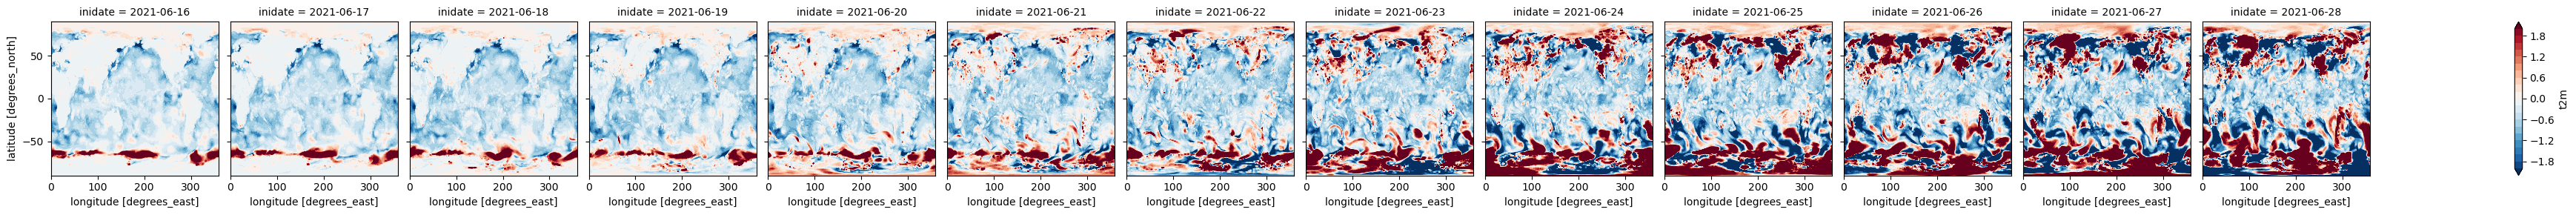

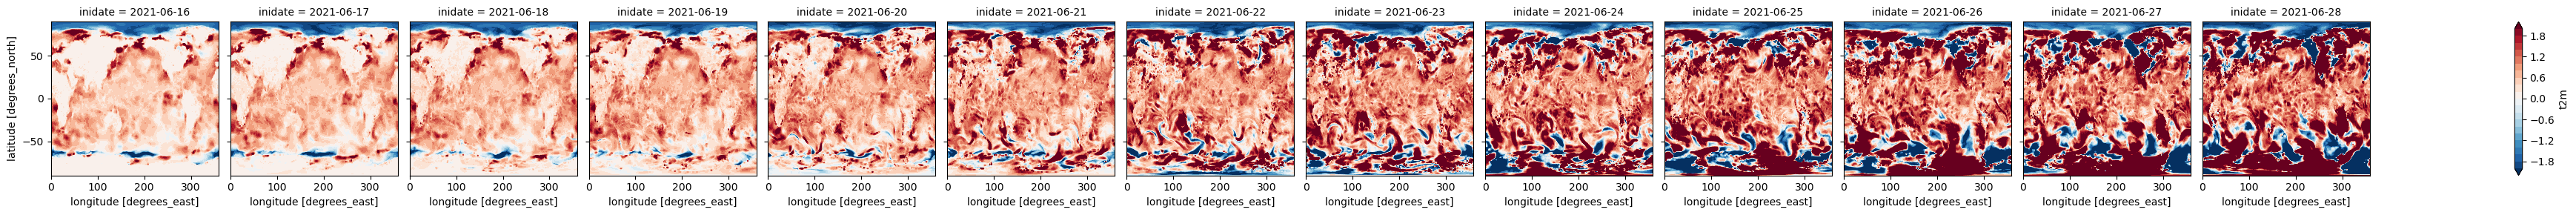

In [22]:
v = 2
delta_maps100['pi']['t+q'].t2m.plot.contourf(col='inidate', vmin=-1*v, vmax=v, cmap='RdBu_r', levels=21, title='pi, t+q')
delta_maps100['incr']['t+q'].t2m.plot.contourf(col='inidate', vmin=-1*v, vmax=v, cmap='RdBu_r', levels=21, title='incr, t+q')

delta_maps100['pi']['progn_vars'].t2m.plot.contourf(col='inidate', vmin=-1*v, vmax=v, cmap='RdBu_r', levels=21, title='pi, progn_vars')
delta_maps100['incr']['progn_vars'].t2m.plot.contourf(col='inidate', vmin=-1*v, vmax=v, cmap='RdBu_r', levels=21, title='incr, progn_vars')

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/xarray/plot/plot.py:1420: UserWarning: The following kwargs were not used by contour: 'title'
  primitive = ax.contourf(x, y, z, **kwargs)


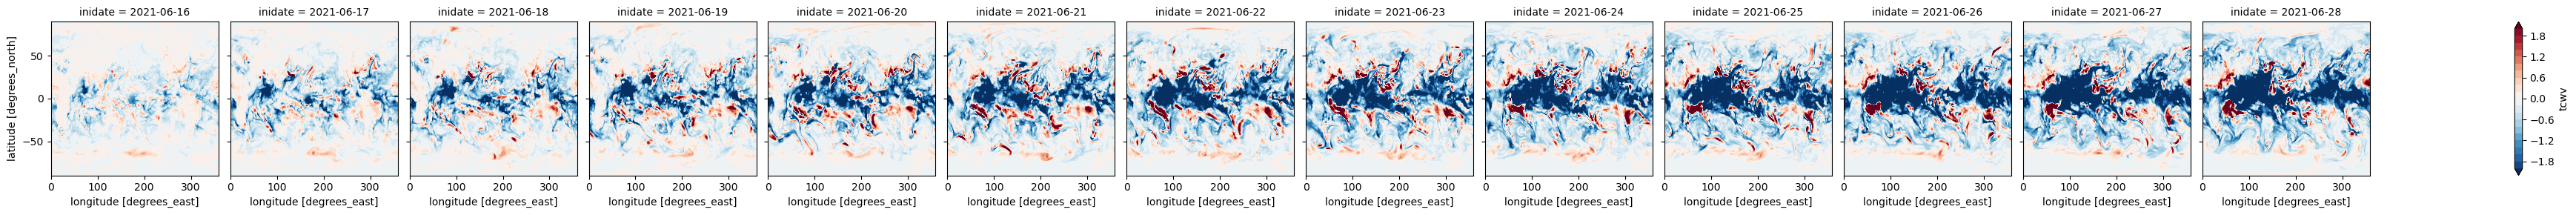

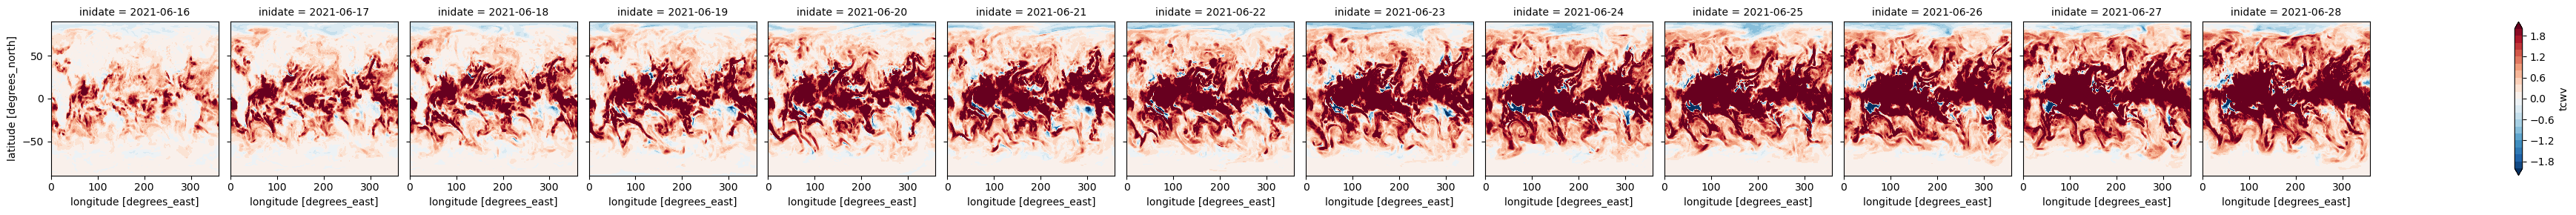

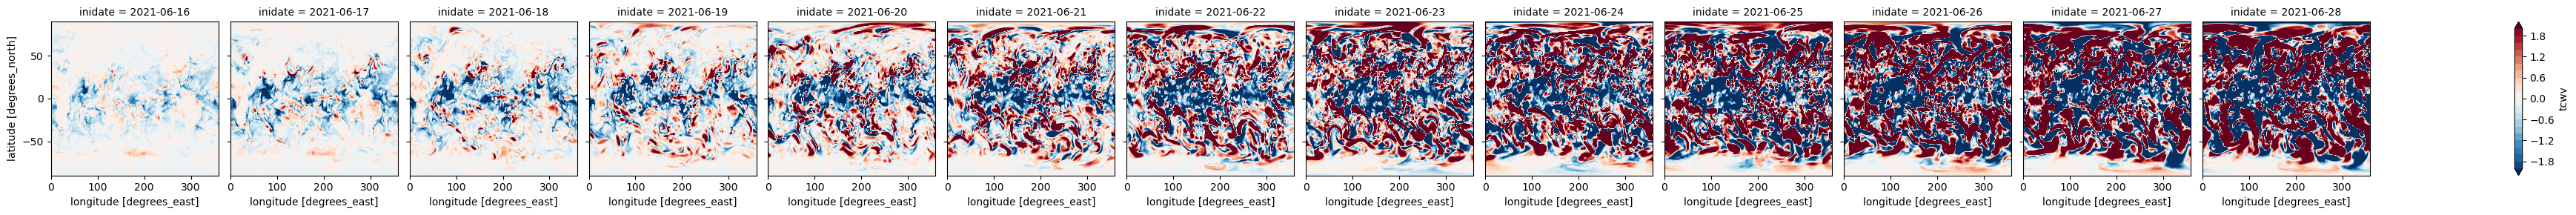

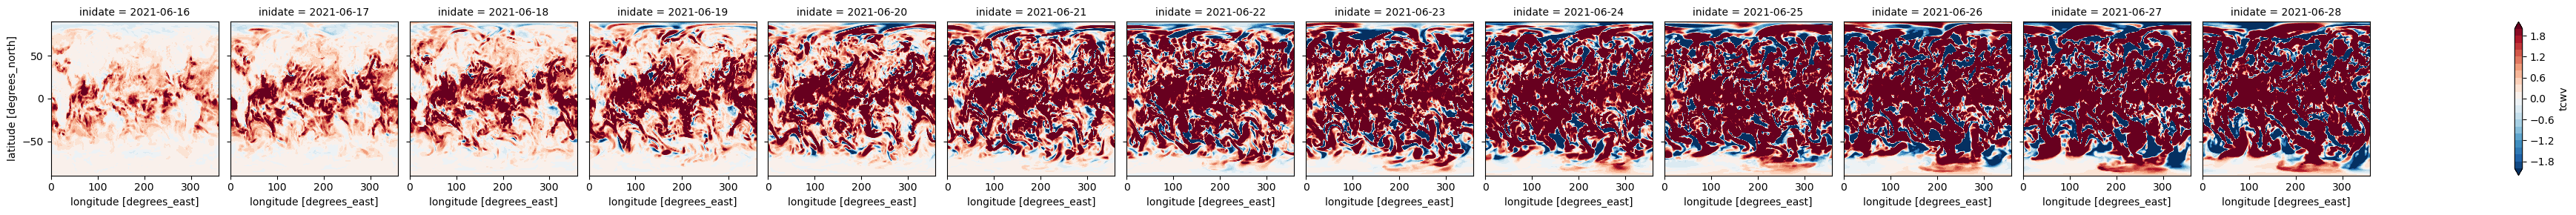

In [24]:
v = 2
delta_maps100['pi']['t+q'].tcwv.plot.contourf(col='inidate', vmin=-1*v, vmax=v, cmap='RdBu_r', levels=21, title='pi, t+q')
delta_maps100['incr']['t+q'].tcwv.plot.contourf(col='inidate', vmin=-1*v, vmax=v, cmap='RdBu_r', levels=21, title='incr, t+q')

delta_maps100['pi']['progn_vars'].tcwv.plot.contourf(col='inidate', vmin=-1*v, vmax=v, cmap='RdBu_r', levels=21, title='pi, progn_vars')
delta_maps100['incr']['progn_vars'].tcwv.plot.contourf(col='inidate', vmin=-1*v, vmax=v, cmap='RdBu_r', levels=21, title='incr, progn_vars')

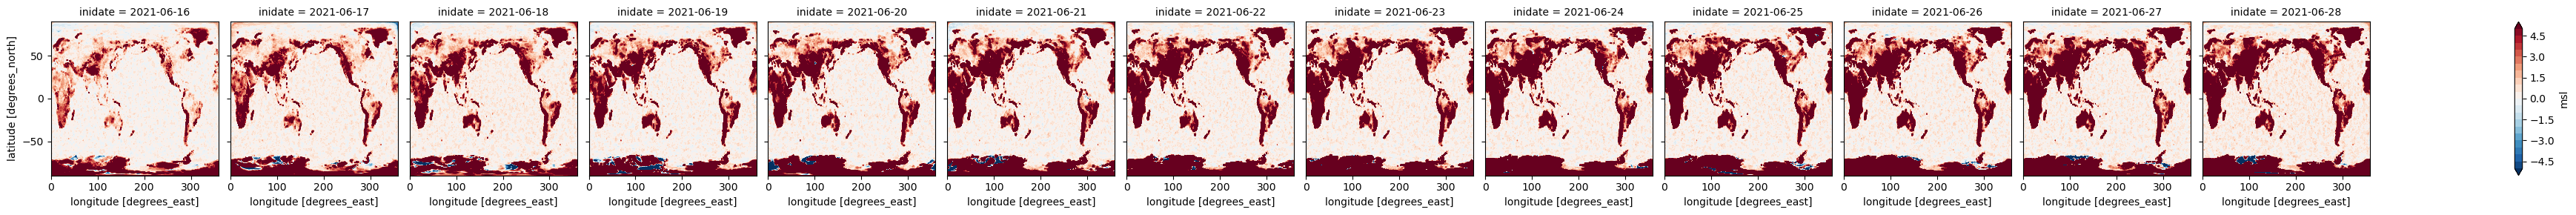

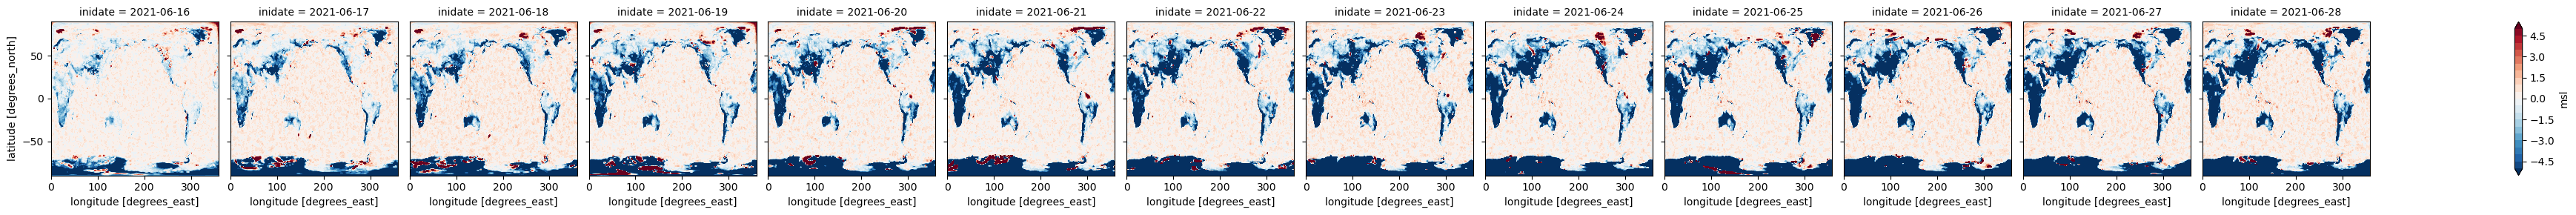

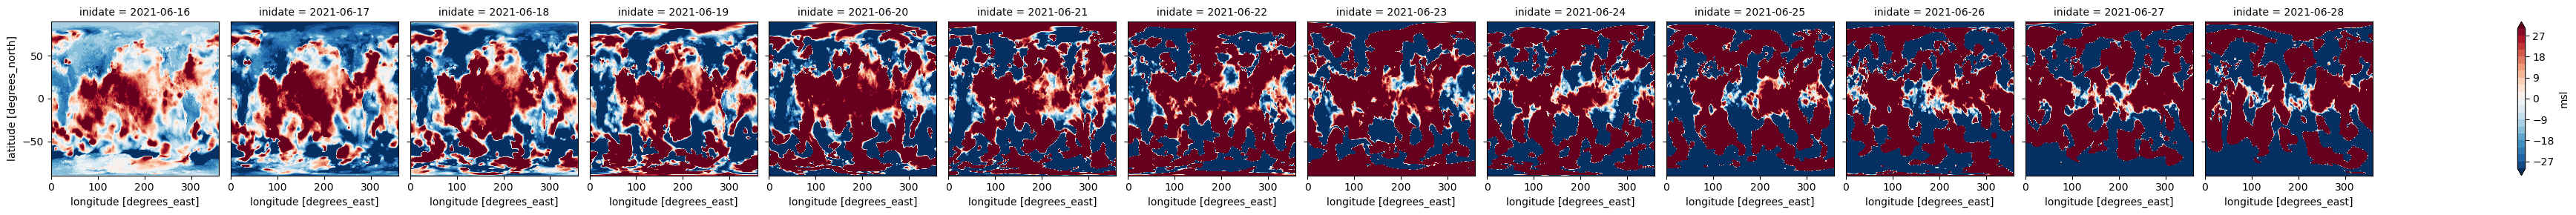

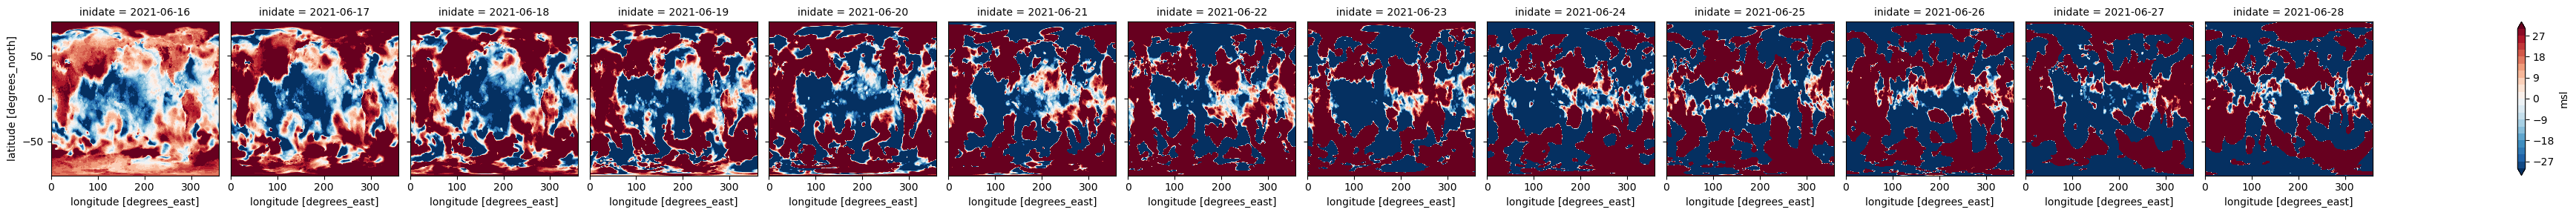

In [28]:
v = 5
delta_maps100['pi']['t+q'].msl.plot.contourf(col='inidate', vmin=-1*v, vmax=v, cmap='RdBu_r', levels=21, title='pi, t+q')
delta_maps100['incr']['t+q'].msl.plot.contourf(col='inidate', vmin=-1*v, vmax=v, cmap='RdBu_r', levels=21, title='incr, t+q')

v = 30
delta_maps100['pi']['progn_vars'].msl.plot.contourf(col='inidate', vmin=-1*v, vmax=v, cmap='RdBu_r', levels=21, title='pi, progn_vars')
delta_maps100['incr']['progn_vars'].msl.plot.contourf(col='inidate', vmin=-1*v, vmax=v, cmap='RdBu_r', levels=21, title='incr, progn_vars')